In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()

<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 11: Non-stationary Time Series

<figure>
<IMG SRC="./images/nino3_wave.png" WIDTH=420 ALIGN="right" STYLE="padding-left:20px" ALT="http://paos.colorado.edu/research/wavelets/wavelet2.html">
</figure>

We saw above in the problem set about the turbulence data that the power spectrum can change a lot during a measurement time period.  That data was highly non-stationary, and you were asked to deal with it by taking a spectrum during a "quiet" and a "turbulent" period.  This was done subjectively, but there are techniques for proceeding more obejctively.

The example on the right is of the surface temperature reflecting the El-Nino signal in the ocean. There are times when the El-Nino periodicity of about 2 years is stronger (i.e. 1880-1920 and 1960-1990) than at other times.  

## Motivating example 1: Chirp

A "chirp" signal changes its frequency with time, and is clearly non-stationary as power moves from low to high frequencies:

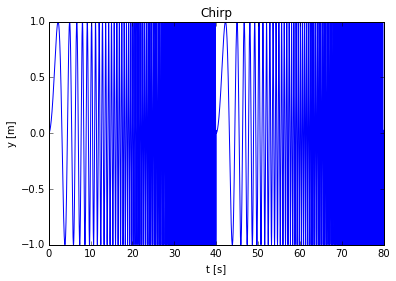

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

t = np.linspace(0,40.,20000)
f0=0.0001
k = 0.05
x = np.sin(2.*np.pi*(f0*t+k*t**2))
t = np.concatenate((t,t+t[-1]))
x = np.concatenate((x,x))
fig,ax=plt.subplots(1,1)
ax.plot(t,x)
plt.ylabel('y [m]')
plt.xlabel('t [s]')
plt.title('Chirp')

The frequency is varying in this signal, and just taking a spectrum would be a bad way of representing the changing frequency:

(1e-05, 1)

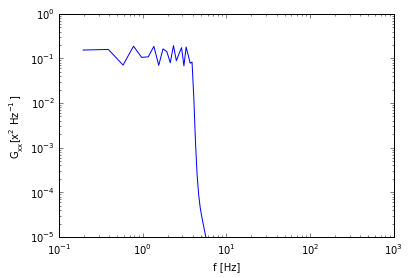

In [8]:
import matplotlib.mlab as mlab
Gx,f = mlab.psd(x,2560,Fs=1/np.median(np.diff(t)))
fig,ax=plt.subplots(1,1)
ax.loglog(f,Gx)
plt.xlabel('f [Hz]');
plt.ylabel(r'$G_{xx} \mathrm{[x^2 Hz^{-1}]}$')
plt.ylim((1e-5,1))

The appropriate frequencies indeed have power, but there is no idea from this plot that the frequency content changes with time.  

## Spectrogram

The spectrogram is a simple and useful way to see the spectral content in time which simply consists of computing a power spectrum over a finite-length window, and plotting the power spectrum versus frequency and time:

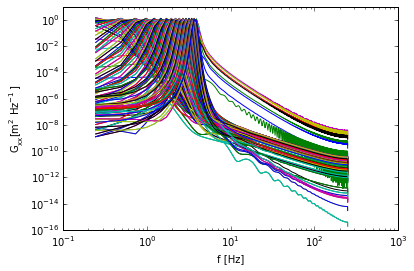

In [14]:
N = np.shape(x)[0]
n = int(np.floor(N/20))
nfft=256*8
Gxx = np.zeros((20*10,nfft/2+1))
num=0
dt = np.median(np.diff(t))
tbin = np.zeros(20*10)
for ind in range(0,N-n,int(np.floor(n/10))):
#    print ind
    px,f=np.squeeze(mlab.psd(x[ind+np.arange(0,n)],nfft,Fs=1/dt))
    Gxx[num,:]=px
    num=num+1
    tbin[num]=np.mean(t[ind+np.arange(0,n)])
tbin=tbin[0:num]
Gxx=Gxx[0:num,:]
fig,ax=plt.subplots(1,1)
ax.loglog(f,Gxx.transpose())
plt.xlabel('f [Hz]');
plt.ylabel(r'$G_{xx} \mathrm{[m^2 Hz^{-1}]}$')


Or, more usefully, we contour in frequency and time:

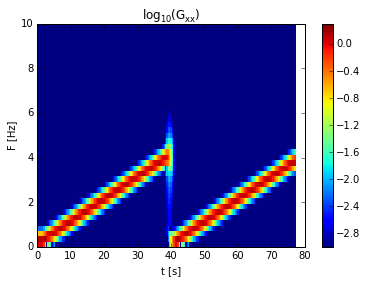

In [17]:
fig,ax=plt.subplots(1,1)
pcm=ax.pcolormesh(tbin,f,np.log10(Gxx.transpose()))
plt.xlim((0,80))
plt.ylim((0,10))
pcm.set_clim((-3,0.3))
plt.colorbar(pcm)
plt.title(r'$log_{10}(G_{xx})$')
plt.xlabel('t [s]')
plt.ylabel('F [Hz]')

The interpretation of this is much clearer.  As time moves on, the frequency of the "chirp" goes up in a linear fashion.  

The difficulty with the spectrogram is that the window of information is the same length for all frequencies.  This probably does not make a lot of sense. For "real" signals high frequencies may vary on a short time scale, and low frequencies on a longer time scale.  **Wavelets** attempt to capture this.


## Example #2

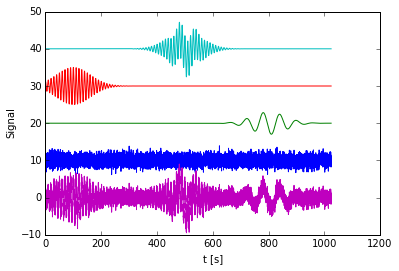

In [19]:
# lets make an x
N=10240
pi = np.pi
x1 = 1.*np.random.randn(N)
t = np.arange(0.,N/10.,1./10.)
f=1./10.
b = 60
x3=5.*np.cos(2*pi*f*t)*np.exp(-(t-100)**2/2/b**2)
x2 = 3.*np.cos(2*pi*f/6.*t)*np.exp(-(t-800)**2/2/(b/1.)**2)
x4=5.*np.cos(2*pi*f*t)*np.exp(-(t-500)**2/2/b**2) +3.*np.cos(2*pi*f/6.*t)*np.exp(-(t-500)**2/2/(b/2.)**2)
x=x1+x2+x3+x4

fig,ax=plt.subplots(1,1)
ax.plot(t,x1+10,t,x2+20,t,x3+30,t,x4+40,t,x)

plt.xlabel('t [s]')
plt.ylabel('Signal')

First, lets take the spectrogram of this:

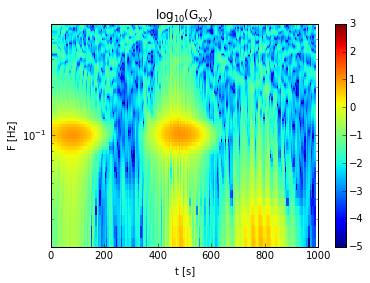

In [44]:
N = np.shape(x)[0]
n = int(np.floor(N/20))  # length of each spectrogram...
nfft=220*10
Gxx = np.zeros((20*10,nfft/2+1))
num=0
dt =np.median(np.diff(t))
tbin = np.zeros(20*10)
for ind in range(0,N-n,int(np.floor(n/10))):
    Gxx[num,:],f=mlab.psd(x[ind+np.arange(0,n)],nfft,Fs=1/dt)
    num=num+1
    tbin[num]=np.mean(t[ind+np.arange(0,n)])
tbin=tbin[:num]
Gxx=Gxx[:num,:]
fig,ax=plt.subplots()
pcm=ax.pcolormesh(tbin,f,np.log10(Gxx.transpose()))
plt.xlim((0,1000))
plt.ylim((0.02,0.5))
pcm.set_clim(-5,3)
fig.colorbar(pcm,ax=ax)
plt.title(r'$log_{10}(G_{xx})$')
plt.xlabel('t [s]')
plt.ylabel('F [Hz]')
ax.set_yscale('log')

This isn't unreasonable as a representation.  However, it requires a bit of tuning to get the correct length of FFTs.  Too short, and the low frequencies are lost, and too long there are not enough spectra to capture the envelope shape.  Wavelets offer and alternative method to accomplish the same thing

## Wavelets: Continuous wavelets

[Wavelets](http://en.wikipedia.org/wiki/Wavelet) are basically localized sine wave packets, where the amplitude of the sine wave is enveloped, so that it tapers to zero at a finite distance from the center of the "wavelet".  This serves to confine the region of analysis to the envelope, allowing localization in time.  Wavelets are then constructed from a **Mother Wavelet** by expanding or contracting the mother wavelet so it picks up lower or higher frequencies. 

A simple mother wavelet is a Gaussian envelope modulating a sine wave:

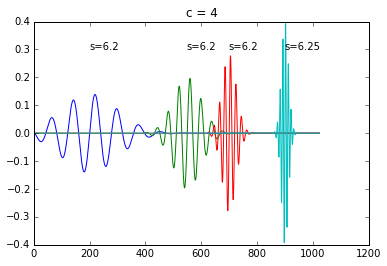

In [49]:
def motherwave(t,tau,s,c):
    # t is time
    # tau is center of the wavelett
    # s is the half width of wavelett, 
    # c is number of oscillations per half wavelett (apprx)
    g = 1/np.sqrt(s)*np.exp(-0.5*((t-tau)/s/2)**2)*np.sin(c*(t-tau)/s)
    return g
tau = 200. # offset in space
s = 50.    # half-width
c = 4.     # number of oscillations
g = motherwave(t,tau,s,c)
fig,ax=plt.subplots()
ax.plot(t,g)
ax.text(tau,0.3,'s=%1.1f' % a)
tau = 550 # offset in space
s = 25 
g = motherwave(t,tau,s,c)
ax.plot(t,g)
ax.text(tau,0.3,'s=%1.1f' % a)
tau = 700
s = 12.5
g = motherwave(t,tau,s,c)
ax.plot(t,g)
ax.text(tau,0.3,'s=%1.1f' % a)
tau = 900
s = 6.25
g = motherwave(t,tau,s,c)
ax.plot(t,g)
ax.text(tau,0.3,'s=%1.2f' % a)
ax.set_title('c = %d'%c)

Here the wavelet envelope has a half-width of $s$, and we specify $c=4$ oscillations per envelope.  As the wavelet gets smaller, it analyzes shorter wavelengths or higher freqeuncies.  Thus, the tradeoff we are used to between long-time observations needed for low frequencies, and only short-time observervations needed for  high-frequency is met in this design.  

The idea of the wavelett transform is the same as that for the Fourier transform.  We define a "scale" $s$ for our envelope, and an offset $\tau$ in time, and convolve our signal with the wavelet $\psi(s,\tau)$:

$$\gamma(s,\tau) = \int_{-\infty}^{\infty}x(t) \psi(s,t-\tau) \ \mathrm{d}t$$

Above our wavelet was 

$$\psi(s,t-\tau) =\frac{1}{\sqrt{a}} \mathrm{e}^{-(t-\tau)^2/2s^2}\sin\left(\frac{c(t-\tau)}{s}\right)$$

The "scale" $s$ sets how wide the wavelet is and how many oscilations it has.  The "offset" says where the wavelet is centered in time.  The resulting co-efficient $\gamma(s,\tau)$ gives us the amplitude of the wavelet present in the signal $x(t)$ centered around $\tau$ at the scale $s$.  

We can discretely approximate to get the amplitude at various scales $s$ and offsets $\tau$:

(98, 102)

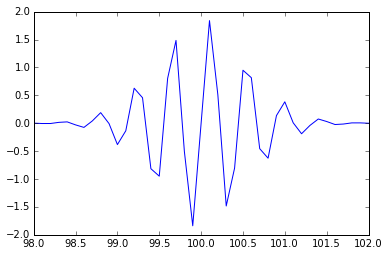

In [51]:
# lets do 100 lateral translations, and 100 different scales.  We'll chose scales to go from 1/2 the domain width to c*2*dt:
I = 12
M = 6
at = np.zeros(I*M)
for i in range(I*M):
    at[i]= 2.**(-(i*1.)/(M*1.))
at = at*t[-1]
#print at
taut = np.linspace(0,t[-1],100)
dt = np.median(np.diff(t))
g = motherwave(t,100,at[-1],c)
fig,ax=plt.subplots()
ax.plot(t,g)   
ax.set_xlim((98,102))

In [52]:
Amp = np.zeros((I*M,100))
nj = 0
for tau in taut:
    ni=0
    for a in at:
        g = motherwave(t,tau,a,c)
        Amp[ni,nj] = np.sum(x*g)
        ni=ni+1
    nj=nj+1

<matplotlib.colorbar.Colorbar instance at 0x11c0c93f8>

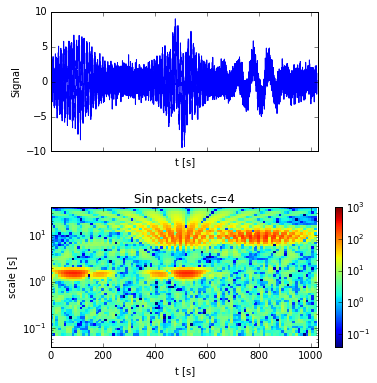

In [84]:
import matplotlib.colors as colors
fig,axs=plt.subplots(2,1,figsize=(6,6),sharex=True)
fig.subplots_adjust(hspace=0.4)
ax=axs[0]
ax.plot(t,x)
ax.set_xlabel('t [s]');ax.set_ylabel('Signal')
cb=fig.colorbar(pcm,ax=ax)
fig.delaxes(cb.ax) # this trick makes a colorbar and then deletes it so the size of axes are same

ax=axs[1]
pcm=ax.pcolormesh(taut,at/c,np.abs(Amp),norm = colors.LogNorm())
ax.set_ylim((0.04,40)); ax.set_xlim(0,1030)
pcm.set_clim((0.04,1000))
ax.set_xlabel('t [s]');ax.set_ylabel('scale [s]');ax.set_title('Sin packets, c=%1.0f' % c)
ax.set_yscale('log')

fig.colorbar(pcm,ax=ax)

So we see that scales of around 10 s light up in two locations: centered at 500 s and 800 s.  Scales of around 2 s light up centered near 100 s and 500 s.  Therefore the wavelet picks up the signals we created at the frequencies and times.  

Note the striping in the amplitude plot above makes things hard to interpret. Thats becayse the phase between the wiggles in the wavelet and the wiggles in the signal don't line up, producing interference patterns. It is possible to ameliorate this problem using "Gabor Waveletts".  In these wavelets the sine-wave is allowed to have arbitrary phase and the wavelet amplitudes are now complex instead of real:

$$\psi(s,\tau) =\frac{1}{\sqrt{a}} \mathrm{e}^{-(t-\tau)^2/2s^2}\mathrm{e}^{jc(t-\tau)/s}$$

In [87]:
def motherwave(t,tau,a,c):
    g = 1/np.sqrt(a)*np.exp(-np.pi*((t-tau)/2/a)**2)*np.exp(np.complex(0.,1.)*c*(t-tau)/a)
    return g

I = 12
M = 6
at = np.zeros(I*M)
for i in range(I*M):
    at[i]= 2.**(-(i*1.)/(M*1.))
at = at*t[-1]
Amp = np.zeros((I*M,100))*np.complex(0.,1.)
nj = 0
for tau in taut:
    ni=0
    for a in at:
        g = motherwave(t,tau,a,c)
        Amp[ni,nj] = np.sum(x*g)
        ni=ni+1
    nj=nj+1

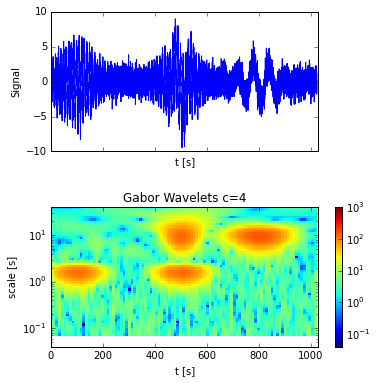

In [97]:
import matplotlib.colors as colors
fig,axs=plt.subplots(2,1,figsize=(6,6),sharex=True)
fig.subplots_adjust(hspace=0.4)
ax=axs[0]
ax.plot(t,x)
ax.set_xlabel('t [s]');ax.set_ylabel('Signal')
cb=fig.colorbar(pcm,ax=ax)
fig.delaxes(cb.ax) # this trick makes a colorbar and then deletes it so the size of axes are same

ax=axs[1]
pcm=ax.pcolormesh(taut,at/c,np.abs(Amp),norm = colors.LogNorm())
ax.set_ylim((0.04,40)); ax.set_xlim(0,1030)
pcm.set_clim((0.04,1000))
ax.set_xlabel('t [s]');ax.set_ylabel('scale [s]');ax.set_title('Gabor Wavelets c=%1.0f' % c)
ax.set_yscale('log')
cb=fig.colorbar(pcm,ax=ax)



Above we have plotted the absolute value of the amplitude of the complex  wavelet co-efficients.  There is also a phase component that we could have plotted if we wanted.  The result is is similar to the basic wavelet above, but now the amplitude is more continuous across the features in the signal.

Note that we can change $c$, the number of oscillations in each wavelet:

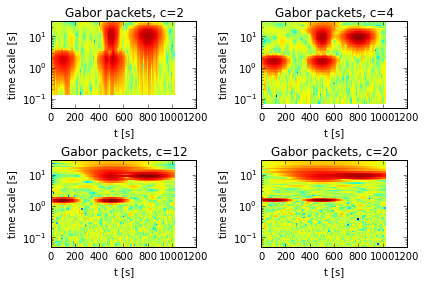

In [127]:
num=0
fig,axs=plt.subplots(2,2)
axs=axs.flatten()


for num,c in enumerate([2., 4., 12., 20.]):
    I = 12
    M = 6
    at = np.zeros(I*M)
    for i in range(I*M):
        at[i]= 2.**(-(i*1.)/(M*1.))
    at = at*t[-1]
    Amp = np.zeros((I*M,100))*np.complex(0.,1.)
    nj = 0
    for tau in taut:
        ni=0
        for a in at:
            g = motherwave(t,tau,a,c)
            Amp[ni,nj] = np.sum(x*g)
            ni=ni+1
        nj=nj+1
    ax=axs[num]

    pcm=ax.pcolormesh(taut,at/c,abs(Amp),norm = colors.LogNorm())
    ax.set_ylim((0.05,300/10.))
    pcm.set_clim((0.01,200))
    ax.set_xlabel('t [s]')
    ax.set_ylabel('time scale [s]')
    ax.set_title('Gabor packets, c=%1.0f' % c)
    ax.set_yscale('log')
fig.tight_layout()

We see that more oscillations in each wavelet does a better job of localizing in "scale", but a poorer job of localizing in time.  So there is still the  tradeoff between resolution in time and in frequency.

## Conditions for a well-formed wavelet

There are many forms possible for wavelets, and there is a whole field of wavelet carpentry.  Such wavelets need to have some relatively obvious properties:
    
   1. The spectral response of the wavelet should be finite, which we can write as 
   
   $$\int \frac{\left| \psi(\omega) \right|^2}{\left|\omega \right|}\ \mathrm{d}\omega < \infty$$
   
   2. The momments vanish 
   
   $$ \int_{-\infty}^{\infty} \psi(t) t\  \mathrm{d}t =0$$
   
   $$ \int_{-\infty}^{\infty} \psi(t) t^2 \mathrm{d}t =0$$
   
   etc..

## Discrete Wavelets: Desaubies Wavelet

The wavelets above were digital approximation of *continuous* wavelets.  They don't conserve information, and are not necessarily orthonormal, and therefore, from an information point of view are not ideal.  

The **Desaubies Wavelett** is a very compact and discrete wavelet that allows us to decompose our signals uniquely into wavelet co-efficients, the same way we can decompose into Fourier co-efficients.  There are other discrete wavelets, but this is one fo the most popular.

Desaubies wavelets consist of the "smoothing" operation and its opposite, the "detail" operation.  If we have $N$ data points, then 

$$C = \begin{pmatrix}
c_0 & c_1 & c_2 & c_3 & 0 & 0& 0 & 0& \cdots  & 0 & 0\\
 c_3 & -c_2 & c_1 & -c_0 &  0 & 0& 0 & 0 & \cdots & 0 &0   \\
0 & 0 & 0& 0 & c_0 & c_1 & c_2 & c_3 &  \cdots  & 0 & 0 \\
0 & 0 & 0& 0 & c_3 & -c_2 & c_1 & -c_0 & \cdots & 0 & 0 \\
&&&&&& & \ddots\\
c_2 & c_3 & 0& 0 & 0& 0 &\cdots & 0& 0 & c_0 & c_1  \\
c_1 & -c_0 & 0& 0 & 0& 0 &\cdots & 0& 0 & c_3 & -c_2  
\end{pmatrix}$$

Where 

\begin{align} 
c_o & = \frac{1+\sqrt{3}}{4\sqrt{2}}\\
c_1 & = \frac{3+\sqrt{3}}{4\sqrt{2}}\\
c_2 & = \frac{3-\sqrt{3}}{4\sqrt{2}}\\
c_3 & = \frac{1-\sqrt{3}}{4\sqrt{2}}\\
\end{align}

These wavelets have the desired properties:
   
   1. normal: $c_o^2+c_1^2+c_2^2+c_3^2 = 1$
   2. orthogonal: $c_2c_0 + c_3c_1 = 0$
   3. "detail" filter returns zero if convolved with a steady signal: $ c_3-c_2+c_1-c_0 = 0$
   4. "smoothing" filter returns zero if convolved with an oscilation: $ 0c_3 - 1 c_2 +2 c_1 -3 c_0 = 0$
   
To compute wavelet co-efficients, we dot $C$ with our data $x$ to get $N$ co-efficients:

$$ Cx = \begin{pmatrix}
s_1\\d_1\\s_2\\d_2 \\ \vdots \\ s_{N/2}\\d_{N/2}
\end{pmatrix}$$

where the $N/2$,  $s_n$ co-efficients are the signal smoothed at the highest-frequency scale, and the $N/2$ $d_n$ co-efficients are the detail at the highest freqeuncy scale.  We save the "detail" co-efficients as the output from our wavelet transform and pass the "smooth" co-efficients to a $N/2\times N/2$ version of $C$.  This returns $N/4$ "detail" co-efficients at the bigger scale, which we keep,  and $N/4$ "smooth" co-efficients which we pass to a $N/4\times N/4$ version of $C$.  We keep doing this until we have $N$ co-efficients in total.  

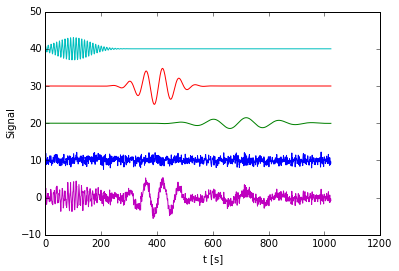

In [130]:
# make the signal:
N=1024
x1 = np.random.randn(N)/1.2
t = np.arange(0.,N,1.)
f=1./30.
b = 60

x3=5.*np.cos(2*pi*f/2*t)*np.exp(-(t-400)**2/2/b**2)
x2 = 1.5*np.cos(2*pi*f/4.*t)*np.exp(-(t-700)**2/2/(2*b)**2)
x4=3.*np.cos(2*pi*f*3*t)*np.exp(-(t-100)**2/2/b**2)
x=x1+x2+x3+x4

fig,ax=plt.subplots()
ax.plot(t,x1+10,t,x2+20,t,x3+30,t,x4+40,t,x)
ax.set_xlabel('t [s]')
ax.set_ylabel('Signal')

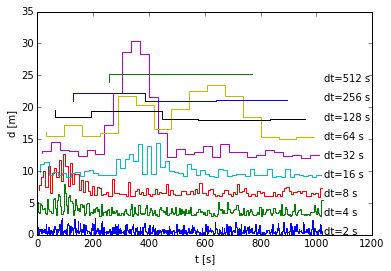

In [134]:
c0=(1.+np.sqrt(3.))/4./np.sqrt(2.)
c1=(3.+np.sqrt(3.))/4./np.sqrt(2.)
c2=(3.-np.sqrt(3.))/4./np.sqrt(2.)
c3=(1.-np.sqrt(3.))/4./np.sqrt(2.)
xn=x
D=[] # this is list of arrays containing the wavelet co-efficients
T=[] # this is a list of arrays containing the times that the co-efficients apply to
num=0
tn=t

while np.shape(xn)[0]>2:
    num=num+1
    N = np.shape(xn)[0]
    # Make the matrix M
    C = np.zeros((N,N))
    for i in range(0,N/2-2):
        C[2*i, 2*i+np.array(range(0,4))]= [c0, c1, c2, c3]
        C[2*i+1, 2*i+np.array(range(0,4))]= [c3, -c2, c1, -c0]
    C[N-2,[0,1]]=[c2,c3]
    C[N-1,[0,1]]=[c1,-c0]
    C[N-2,[N-2,N-1]]=[c0,c1]
    C[N-1,[N-2,N-1]]=[c3,-c2]

    # get the wavelet co-efficients at this scale
    S = np.dot(C,xn)
    # save the "detail" co-efficients
    D.append(S[range(1,N,2)])
    # figure out what time the "details" each apply to.
    T.append(tn[range(1,N,2)])
    # take every second time for the next iteration
    tn = tn[range(0,N,2)]
    # make xn the "smooth" part of the previous. so it is N/2 long
    xn=S[range(0,N,2)]
D.append(xn)

# plot the co-efficients
num=0
fig,ax=plt.subplots()
for d in D[0:-1]:
    ax.step(T[num],abs(d)+num*3)
    ax.text(1026,num*3,'dt=%d s'% (np.median(np.diff(T[num]))))
    num=num+1
ax.set_xlabel('t [s]')
ax.set_ylabel('d [m]')


Here we have plotted the wavelet co-efficients versus time. The time series is 1024 s long, asmpled at 1 Hz.  There are $1024/2 = 512$ co-effcients in the blue line, $256$ co-efficients in the green line, etc.  There are two co-efficients at $dt = 512$

So, we see that this picked up peaks in the magenta and yellow lines, which correspond to dt=32 s and dt=64 s, or frequencies near .032 and 0.0156 Hz.  The red line at 8 s and the cyan line at 16-s scale picks up the early high-frequency signal.  

### Compression with wavelets

The signal $x(t)$ is exactly recoverable using the inverse of the procedure above using the wavelet co-effcients in the same way that the inverse of the Fourier transform can recover the signal from the Fourier co-efficients.  

In [135]:
print np.shape(D[0])

(512,)


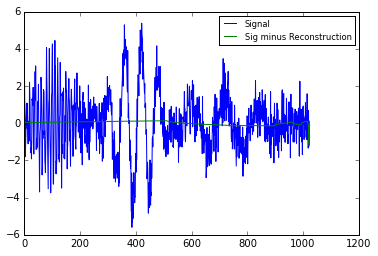

In [140]:
def invertWavelet(D):
# return the signal using the co-effcients in D
    n = 0
    s = D.pop()
    while np.shape(D)[0]>0:
        d=D.pop()
        sn = np.concatenate([s,d])
        s=1.*sn
        N = np.shape(sn)[0]
        s[range(0,N,2)]=sn[range(0,N/2)]
        s[range(1,N,2)]=sn[range(N/2,N)]
        C = np.zeros((N,N))

        for i in range(0,N/2-2):
            C[2*i, 2*i+np.array(range(0,4))]= [c0, c1, c2, c3]
            C[2*i+1, 2*i+np.array(range(0,4))]= [c3, -c2, c1, -c0]
        C[N-2,[0,1]]=[c2,c3]
        C[N-1,[0,1]]=[c1,-c0]
        C[N-2,[N-2,N-1]]=[c0,c1]
        C[N-1,[N-2,N-1]]=[c3,-c2]
        s = np.dot(C.transpose(),s)
    return s
D0=list(D)
xn=invertWavelet(D0)
fig,ax=plt.subplots()
ax.plot(x,label='Signal')
ax.plot(x-xn,label='Sig minus Reconstruction')
ax.legend(fontsize='small')

So, aside from some small edge effects, the signal is well-recovered. 

However, we might expect from the amplitudes above that a lot of the signal is just in a few of the wavelet co-efficients.  So we can trim most of the 1024 co-efficients, and invert to recover the signal.

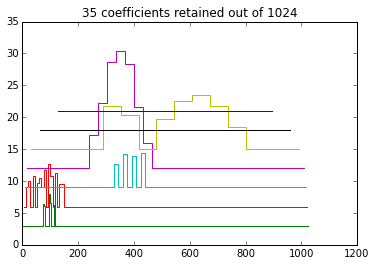

In [145]:
Dnew =[]
thresh=3.
num=0
for d in D:
    dd=1.*d
    dd[(abs(d))<thresh]=0.
    Dnew.append(dd)
#    step(T[num],abs(dd)/sqrt(2**num)+num*3)
    num=num+1
#Dnew[0]=Dnew[0]*0.

#Dnew[1]=Dnew[1]*0.

num=0
ngood=0
fig,ax=plt.subplots()
for d in Dnew[0:-2]:
    ngood = sum(abs(d)>0)+ngood
    ax.step(T[num],abs(d)+num*3)
    num=num+1
ax.set_title('%d coefficients retained out of %d' % (ngood,np.shape(x)[0]))

So here we have thrown out all signals weaker than an arbitrary threshold.  Note that sometimes a certain scale is zeroed out, and other times its active.  This gives the wavelett more flexibility than just a Fourier-domain filter: If the high frequencies become important (i.e. 0-150 s above) then they are retained during that time period, and ignored other times.

Reconstituting the signal:

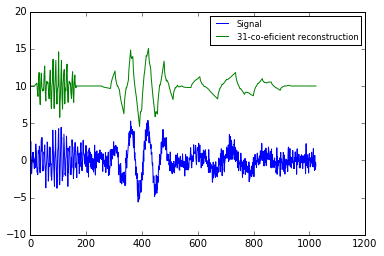

In [147]:
D0=list(Dnew)
xn=invertWavelet(D0)
fig,ax=plt.subplots()
ax.plot(x,label='Signal')
ax.plot(xn+10,label='31-co-eficient reconstruction')
ax.legend(fontsize='small')

So we have recovered a decent representation of the signal with only 35 co-efficients (out of 1024) for a factor of 33 compression.  Wavelets are used extensively in audio, image, and video compression. 